## Twitter User Account Classification

Classifying twitter user accounts as being accounts of individuals, and organizations. The description provided by the user is used to build a classification model.

To train the model intially, we have collected the labelled data. 

- Class = 0 refers to Organization
- Class = 1 refers to Individual

In [2]:
import pandas as pd

In [3]:
df_user_labelled = pd.read_excel(r'./Twitter_User_Classification_Training_Data.xlsx')

Let us have a look at the data after removing accounts with missing descriptions

In [4]:
df_user_labelled = df_user_labelled[~df_user_labelled['User_Description'].isnull()]
df_user_labelled

,User_Description,User_Account_Type,User_Account_Type_Class
0,Augmented Reality glasses are going to change ...,organization,0
1,san francisco - dallas | marketer | typical di...,individual,1
2,"Independent craft brewery in Oranmore, Co. Gal...",organization,0
3,Helping you respond to challenges is our respo...,organization,0
4,Grimpe Communicatie | technologie | financials...,individual,1
...,...,...,...
55436,Provost and Executive Vice President / Adelphi...,individual,1
55437,yes you canâœŒï¸ðŸ˜ŽðŸ·,individual,1
55438,On an adventure with @zoefriedland and E.,individual,1
55439,Everything you want to know about your favorit...,organization,0


#### Cleaning the User Description Field

Let us use some regular expressions to clean our description column and save it back to our database for future analysis
- We remove characters from the description
- Make it all lower case (HELLO and hello are pretty similar for our task)
- We remove the URLs from the description
- In future models, we might remove some stop words such as you, you'are, could, now, only, etc. that do not add value to the description analysis

In [5]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"http", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"@\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", regex=True)
    df[text_field] = df[text_field].str.replace(r"@", "at", regex=True)
    df[text_field] = df[text_field].str.lower()
    return df

df_user_labelled = standardize_text(df_user_labelled, 'User_Description')
df_user_labelled.head()

,User_Description,User_Account_Type,User_Account_Type_Class
0,augmented reality glasses are going to change ...,organization,0
1,san francisco dallas marketer typical di...,individual,1
2,"independent craft brewery in oranmore, co gal...",organization,0
3,helping you respond to challenges is our respo...,organization,0
4,grimpe communicatie technologie financials...,individual,1


Let's look at our class balance. We see our classes below are pretty balanced

In [6]:
df_user_labelled.groupby("User_Account_Type").count()

,User_Description,User_Account_Type_Class
User_Account_Type,,
individual,27502,27502
organization,27926,27926


#### Our data is clean. Now it needs little preparation
We use user description to predict User_Account_Type_Class. Now, we need to transform (see below) our input field so that the models can understand. 
- Tokenizing a sentence to a list of separate words.
- Creating a train and test split
- Inspecting our data more to validate the results

In [7]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

df_user_labelled['User_Description_Tokens'] = df_user_labelled['User_Description'].apply(tokenizer.tokenize)
df_user_labelled

,User_Description,User_Account_Type,User_Account_Type_Class,User_Description_Tokens
0,augmented reality glasses are going to change ...,organization,0,"[augmented, reality, glasses, are, going, to, ..."
1,san francisco dallas marketer typical di...,individual,1,"[san, francisco, dallas, marketer, typical, di..."
2,"independent craft brewery in oranmore, co gal...",organization,0,"[independent, craft, brewery, in, oranmore, co..."
3,helping you respond to challenges is our respo...,organization,0,"[helping, you, respond, to, challenges, is, ou..."
4,grimpe communicatie technologie financials...,individual,1,"[grimpe, communicatie, technologie, financials..."
...,...,...,...,...
55436,provost and executive vice president adelphi...,individual,1,"[provost, and, executive, vice, president, ade..."
55437,yes you can,individual,1,"[yes, you, can]"
55438,on an adventure with and e,individual,1,"[on, an, adventure, with, and, e]"
55439,everything you want to know about your favorit...,organization,0,"[everything, you, want, to, know, about, your,..."


#### Inspecting our User Description little more

In [8]:
#!{sys.executable} -m pip install keras
#!{sys.executable} -m pip install --user --no-warn-script-location tensorflow
import tensorflow
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

all_words = [word for User_Description_Tokens in df_user_labelled['User_Description_Tokens'] 
             for word in User_Description_Tokens]

sentence_lengths = [len(tokens) for tokens in df_user_labelled['User_Description_Tokens']]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))


828186 words total, with a vocabulary size of 71419
Max sentence length is 50


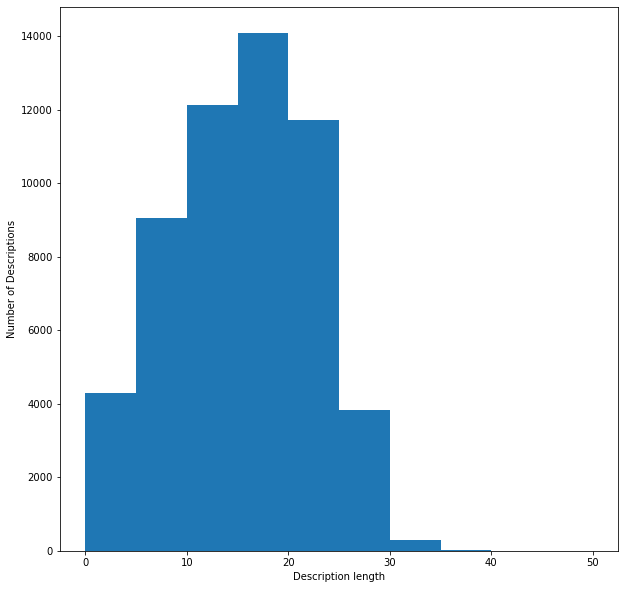

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Description length')
plt.ylabel('Number of Descriptions')
plt.hist(sentence_lengths)
plt.show()

### On to Machine Learning
Now the data is cleaned and prepared. Let us apply Natural Language Processing. Let us first create an useful embedding for each user account and see if they help us to predict the account type. Let us start with the simple approach and start with the Bag of words model and then apply Logistic Regression.

#### Approach 1: Bag of Words Count

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

list_corpus = df_user_labelled["User_Description"].tolist()
list_labels = df_user_labelled["User_Account_Type_Class"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

#### Visualizing the Embeddings

Now that we have created the embeddings, we can visualize them and see if we can identify some structure. Since visualizing 
in many dimesions is hard, let us project down to 2 dimensions.

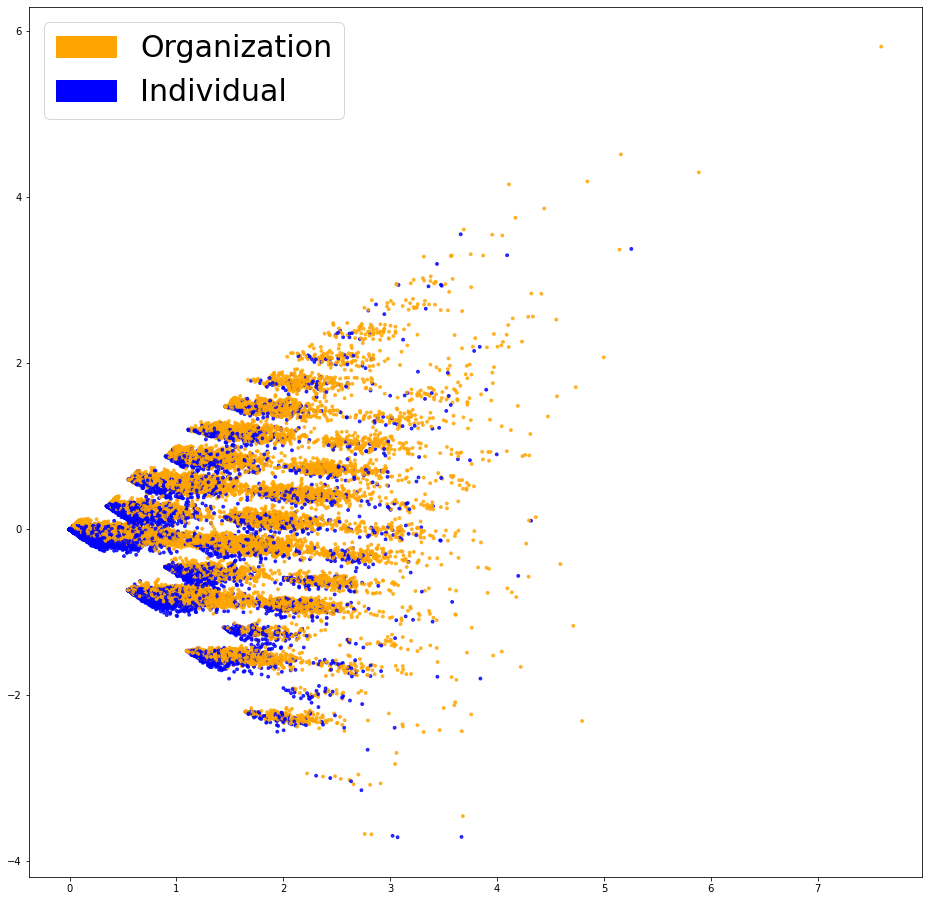

In [11]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Organization')
            green_patch = mpatches.Patch(color='blue', label='Individual')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

These embeddings don't look very clean. Let us see if we can still fit an useful model on them.

#### Fitting a classifier

Let us fit a simple logistic regression classifier.

In [12]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

#### Evaluation

Let us see our metrics to evaluate if our classified performed well.

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.901, precision = 0.901, recall = 0.901, f1 = 0.901


Let us look at the confusion matrics to identify the list of mistakes that our classifier is making.

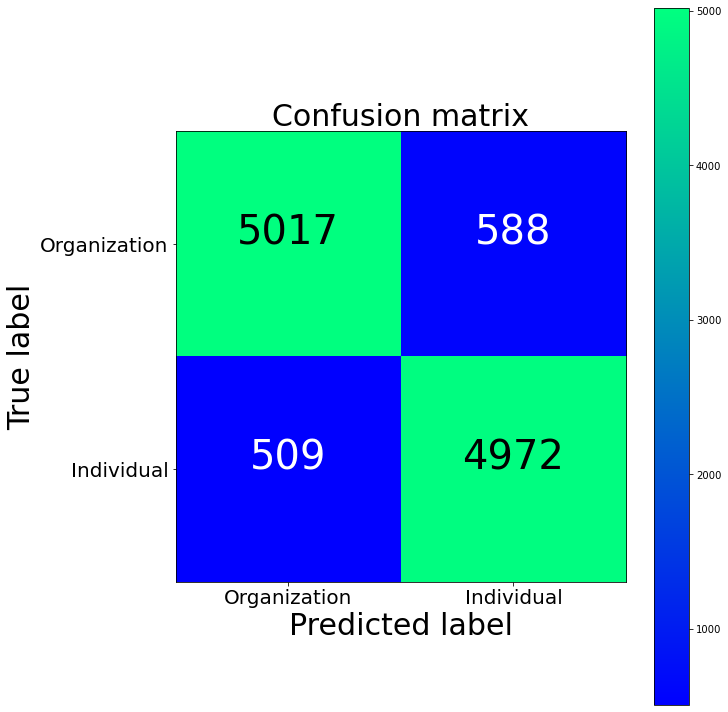

[[5017  588]
 [ 509 4972]]


In [14]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Organization', 'Individual'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

Let us look at the features that our classifier is using to make decisions

In [15]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

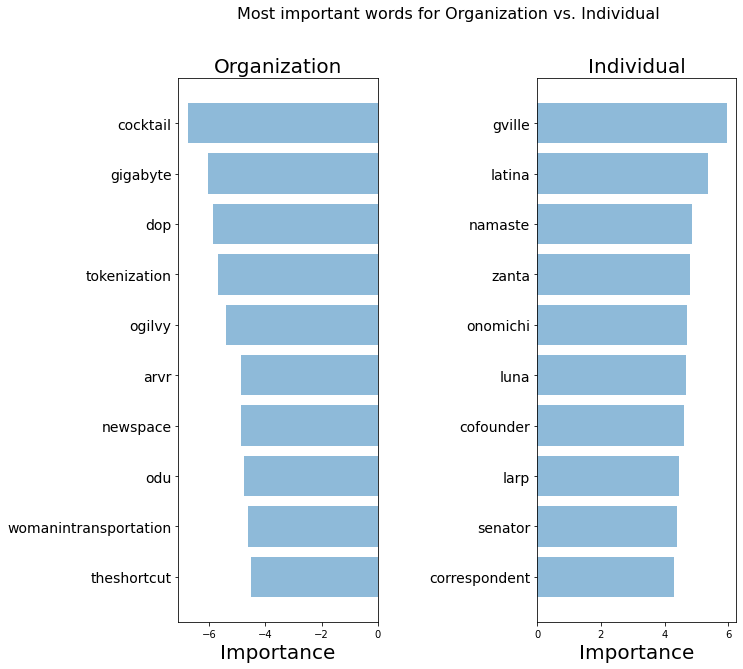

In [16]:

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Organization', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Individual', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

   
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for Organization vs. Individual")

Our classifier correctly picks up on some patterns (Senator, Cofounder). However, some of the words are irrelevant

#### Approach 2: TFIDF Bag of Words

Let us use a different approach. We can use TF-IDF (Term Frequency, Inverse Document Frequency), i.e. weighing words by how frequent they are in our dataset. 

In [27]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

list_corpus = df_user_labelled["User_Description"].tolist()
list_labels = df_user_labelled["User_Account_Type_Class"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

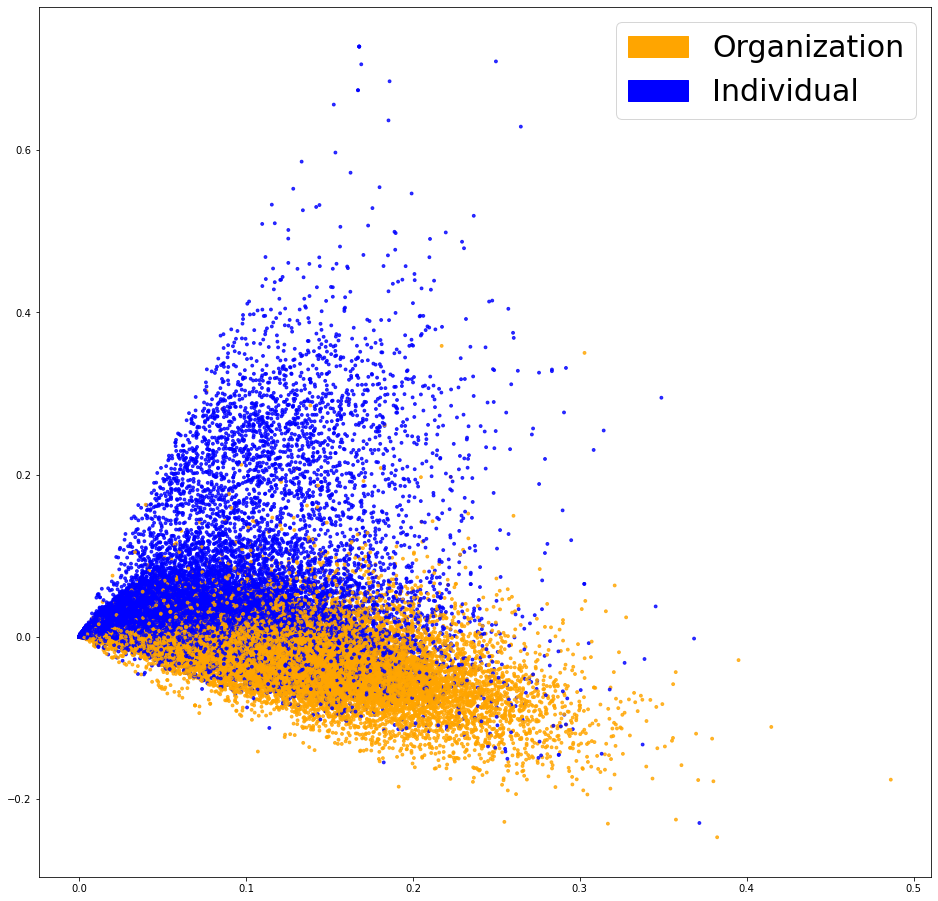

In [18]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

The embeddings look much more separated compared to **Approach 1**. Let us see if our Logistic regression classifier leads to a better performance now.

In [20]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.915, precision = 0.915, recall = 0.915, f1 = 0.915


The results are a little better, let's see if they translate to an actual difference in our use case.

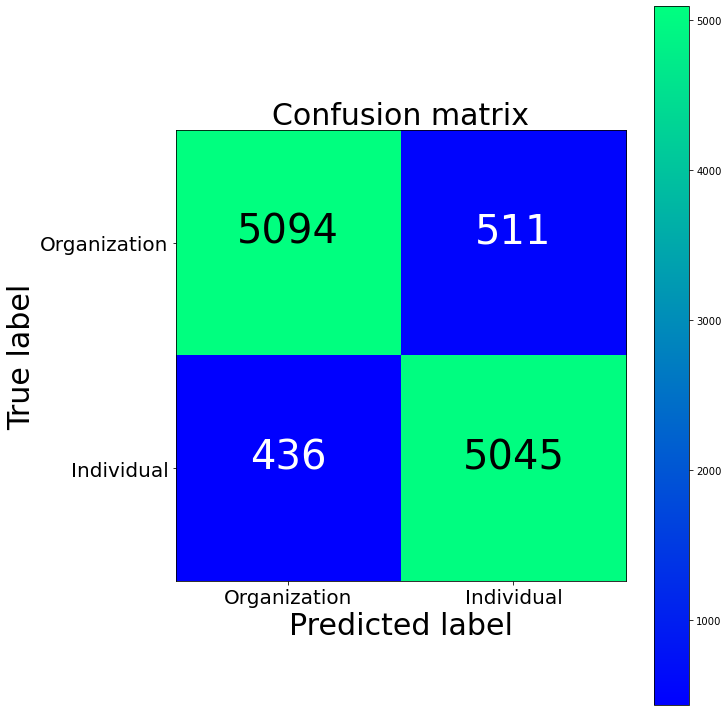

TFIDF confusion matrix
[[5094  511]
 [ 436 5045]]
BoW confusion matrix
[[5017  588]
 [ 509 4972]]


In [21]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Organization','Individual'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Looking at important Coefficients for Linear Regression

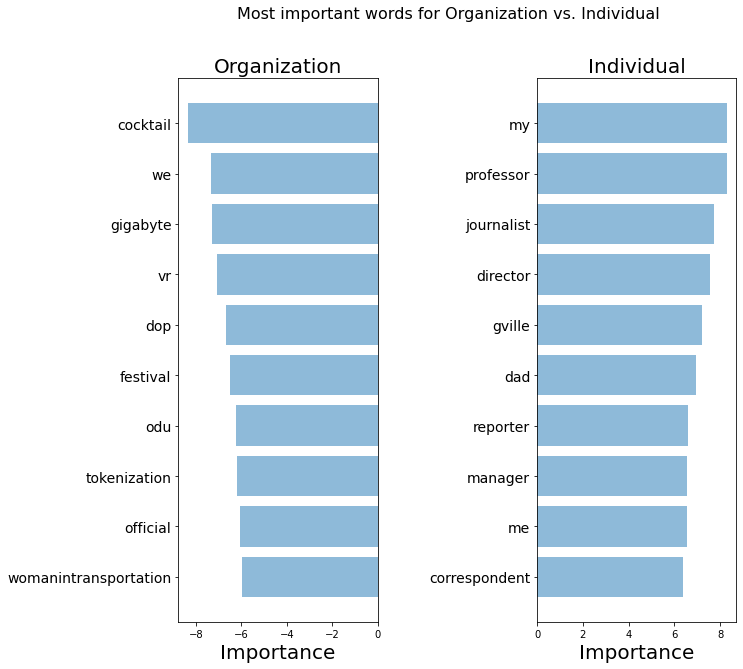

In [22]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for Organization vs. Individual")

The words picked up in Individual class is much more relevant. We are little more confident in using this model

In [23]:
#!{sys.executable} -m pip install lime
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

p1 = make_pipeline(tfidf_vectorizer, clf_tfidf)
explainer = LimeTextExplainer(class_names=["Organization","Individual"]) 

idx=30

exp = explainer.explain_instance(X_test[idx], 
                                 p1.predict_proba, 
                                 num_features=10)
print('Id: %d' % idx)
print('True class: %s' % y_test[y_test[idx]])
print('R2 score: {:.3f}'.format(exp.score))
exp.show_in_notebook(text=True)

Id: 30
True class: 0
R2 score: 0.298


### Conclusion

We saw that the **TFIDF + LR** performed better than **Bag of Words** approach in predicting the Twitter account type.
(Individual vs. Organization)

#### Let us save the TFIDF + LR model for future use. 

In [29]:
from joblib import dump

# save the model to disk
filename = 'Twitter_accounttype_classification_model.sav'
pickle.dump(tfidf, clf_tfidf, open(filename, 'wb'))

TypeError: an integer is required (got type _io.BufferedWriter)

In [33]:
import joblib

# Save clf_tfidf model to file in the current working directory

model = "Twitter_accounttype_classification_model.pkl"  
joblib.dump(clf_tfidf, model)

vectorizer = "vectorizer.pkl"
joblib.dump(tfidf_vectorizer, vectorizer)





['vectorizer.pkl']